In [ ]:
import json
import os

def calculate_inappropriate_reliance(results) -> float:
    reliance_score = 0.0
    filtered_results = [r for r in results if not r['ai_is_correct']]
    num_relied = len([r for r in filtered_results if r['final_guess_agrees_with_ai']])
    return num_relied / len(filtered_results)

def calculate_appropriate_reliance(results) -> float:
    reliance_score = 0.0
    filtered_results = [r for r in results if r['ai_is_correct']]
    num_relied = len([r for r in filtered_results if r['final_guess_agrees_with_ai']])
    return num_relied / len(filtered_results)


experiments_folder = "/home/tejas/projects/messing_around/experiments/dataset-mmlu_clinical/simulated_user-llama2_7b"
experiments_filenames = os.listdir(experiments_folder)
all_results = []
for filename in experiments_filenames:
    if filename.endswith(".json"):
        with open(os.path.join(experiments_folder, filename), "r") as f:
            experiment_results = json.load(f)
            experiment_name = experiment_results["experiment_name"]
            experiment_str = experiment_name.split("assistant-")[-1].replace("_", "\n").replace("ectconf_", ":")
            #print(experiment_str)
            experiment_results["experiment_str"] = experiment_str
            #experiment_results["appropriate_reliance"] = calculate_appropriate_reliance(experiment_results['rollout_results'])
            #experiment_results["inappropriate_reliance"] = calculate_inappropriate_reliance(experiment_results['rollout_results'])

            all_results.append(experiment_results)
print(f"Total experiments loaded: {len(all_results)}")
            

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")
df = pd.DataFrame.from_dict(all_results)

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x="assistant_calibration_error", 
    y="appropriate_reliance", 
    hue="assistant_accuracy", 
    size="final_user_accuracy", 
    data=df, 
    ax=ax,
    sizes=(50, 300),
    palette="flare", 
    #hue_norm=(0, 1), size_norm=(0, 1),

)
sns.move_legend(ax, "lower left", bbox_to_anchor=(1, 0))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']), fontdict={"size": 10})

label_point(df.assistant_calibration_error, df.appropriate_reliance, df.experiment_str, plt.gca()) 


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")
df = pd.DataFrame.from_dict(all_results)

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x="assistant_calibration_error", 
    y="inappropriate_reliance", 
    hue="assistant_accuracy", 
    size="final_user_accuracy", 
    data=df, 
    ax=ax,
    sizes=(50, 300),
    palette="flare", 
    #hue_norm=(0, 1), size_norm=(0, 1),

)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']), fontdict={"size": 10})

label_point(df.assistant_calibration_error, df.inappropriate_reliance, df.experiment_str, plt.gca()) 


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")
df = pd.DataFrame.from_dict(all_results)

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x="assistant_calibration_error", 
    y="switch_percentage", 
    hue="assistant_accuracy", 
    size="final_user_accuracy", 
    data=df, 
    ax=ax,
    sizes=(50, 300),
    palette="flare", 
    #hue_norm=(0, 1), size_norm=(0, 1),

)
sns.move_legend(ax, "lower left", bbox_to_anchor=(1, 0))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']), fontdict={"size": 10})

label_point(df.assistant_calibration_error, df.switch_percentage, df.experiment_str, plt.gca()) 


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")
df = pd.DataFrame.from_dict(all_results)

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x="assistant_calibration_error", 
    y="agreement_percentage", 
    hue="assistant_accuracy", 
    size="final_user_accuracy", 
    data=df, 
    ax=ax,
    sizes=(50, 300),
    palette="flare", 
    #hue_norm=(0, 1), size_norm=(0, 1),

)
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']), fontdict={"size": 10})

label_point(df.assistant_calibration_error, df.agreement_percentage, df.experiment_str, plt.gca()) 


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")
df = pd.DataFrame.from_dict(all_results)

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x="assistant_calibration_error", 
    y="final_user_accuracy", 
    hue="assistant_accuracy", 
    #size="final_user_accuracy", 
    data=df, 
    ax=ax,
    s=200,
    palette="flare", 
    #hue_norm=(0, 1), size_norm=(0, 1),

)
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']), fontdict={"size": 10})

label_point(df.assistant_calibration_error, df.final_user_accuracy, df.experiment_str, plt.gca()) 

In [ ]:
# For each experiment, plot histogram of AI confidences when AI was correct and when AI was wrong
fig, ax = plt.subplots(len(all_results), 1, figsize=(8, 5*len(all_results)))
print(len(ax))
for i, exp in enumerate(all_results):
    #fig, ax = plt.subplots(figsize=(8, 4))
    ai_correct_confidences = [r['assistant_conf'] for r in exp['rollout_results'] if r['assistant_is_correct']]
    ai_wrong_confidences = [r['assistant_conf'] for r in exp['rollout_results'] if not r['assistant_is_correct']]
    sns.histplot(ai_correct_confidences, color="blue", ax=ax[i], bins=20, label="AI Correct")
    sns.histplot(ai_wrong_confidences, color="red", ax=ax[i], bins=20, label="AI Wrong")
    plot_title = exp['experiment_str'].replace('\n', '-') + f"  calibration_error:{exp['assistant_calibration_error']:.4f}"
    ax[i].set_title(plot_title)
    ax[i].set_xlim(0, 1)
    ax[i].legend()
plt.show()

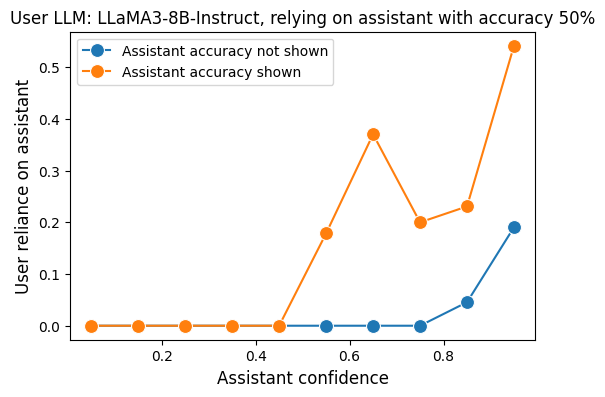

In [11]:
import os
import json

LLM_TO_DISPLAYNAME = {
    "mistral_7b_instruct": "Mistral-7B-Instruct",
    "llama3_8b_instruct": "LLaMA3-8B-Instruct",
}
llm_name = "llama3_8b_instruct"
assistant_accuracy = 0.5

experiments_dir = "/home/tejas/projects/messing_around/experiments/1stage_game/dataset-mmlu_clinical"
fn1 = os.path.join(experiments_dir, f"simulated_user-{llm_name}/assistant-{assistant_accuracy:.1f}acc_alwaysuniformconf.json")
fn2 = os.path.join(experiments_dir, f"simulated_user-{llm_name}-assistant_acc_aware/assistant-{assistant_accuracy:.1f}acc_alwaysuniformconf.json")

with open(os.path.join(experiments_dir, fn1), "r") as f:
    exp1 = json.load(f)
    exp1_results = exp1['rollout_results']

with open(os.path.join(experiments_dir, fn2), "r") as f:
    exp2 = json.load(f)
    exp2_results = exp2['rollout_results']

import seaborn as sns
import matplotlib.pyplot as plt

exp1_reliances, exp2_reliances = [], []
for i in range(10):
    exp1_filtered_results = [r for r in exp1_results if r['assistant_conf'] >= i/10 and r['assistant_conf'] < (i+1)/10]
    exp2_filtered_results = [r for r in exp2_results if r['assistant_conf'] >= i/10 and r['assistant_conf'] < (i+1)/10]
    exp1_reliance = len([r for r in exp1_filtered_results if r['user_agrees_with_assistant']]) / len(exp1_filtered_results)
    exp2_reliance = len([r for r in exp2_filtered_results if r['user_agrees_with_assistant']]) / len(exp2_filtered_results)
    exp1_reliances.append(exp1_reliance)
    exp2_reliances.append(exp2_reliance)

fig, ax = plt.subplots(figsize=(6, 4))
plt.title(f"User LLM: {LLM_TO_DISPLAYNAME[llm_name]}, relying on assistant with accuracy {assistant_accuracy:.0%}")
sns.lineplot(x=[i/10+0.05 for i in range(10)], y=exp1_reliances, label="Assistant accuracy not shown", ax=ax, marker='o', markersize=10)
sns.lineplot(x=[i/10+0.05 for i in range(10)], y=exp2_reliances, label="Assistant accuracy shown", ax=ax, marker='o', markersize=10)
ax.set_xlabel("Assistant confidence", fontsize=12)
ax.set_ylabel("User reliance on assistant", fontsize=12)
plt.show()

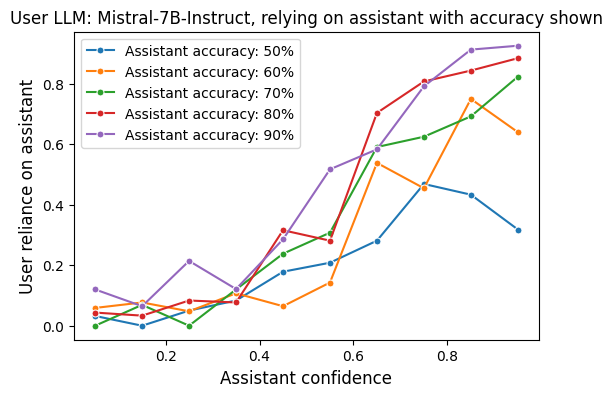

In [20]:
import os
import json

LLM_TO_DISPLAYNAME = {
    "mistral_7b_instruct": "Mistral-7B-Instruct",
    "llama3_8b_instruct": "LLaMA3-8B-Instruct",
}
llm_name = "mistral_7b_instruct"

experiments_dir = "/home/tejas/projects/messing_around/experiments/1stage_game/dataset-mmlu_clinical"

def calculate_reliance(assistant_acc):
    fn = os.path.join(experiments_dir, f"simulated_user-{llm_name}-assistant_acc_aware/assistant-{assistant_acc:.1f}acc_alwaysuniformconf.json")
    with open(os.path.join(experiments_dir, fn), "r") as f:
        exp = json.load(f)
        exp_results = exp['rollout_results']

    exp_reliances = []
    for i in range(10):
        exp_filtered_results = [r for r in exp_results if r['assistant_conf'] >= i/10 and r['assistant_conf'] < (i+1)/10]
        exp_reliance = len([r for r in exp_filtered_results if r['user_agrees_with_assistant']]) / len(exp_filtered_results)
        exp_reliances.append(exp_reliance)
    return exp_reliances

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
plt.title(f"User LLM: {LLM_TO_DISPLAYNAME[llm_name]}, relying on assistant with accuracy shown")
for assistant_accuracy in [0.5, 0.6, 0.7, 0.8, 0.9]:
    exp_reliances = calculate_reliance(assistant_accuracy)
    sns.lineplot(x=[i/10+0.05 for i in range(10)], y=exp_reliances, label=f"Assistant accuracy: {assistant_accuracy:.0%}", ax=ax, marker='o', markersize=5)

ax.set_xlabel("Assistant confidence", fontsize=12)
ax.set_ylabel("User reliance on assistant", fontsize=12)
plt.show()